# 確率ロボティクス課題
**拡張カルマンフィルタ**  
適当なノイズを与え制御入力とランドマークの計測結果から姿勢の推定を行う


In [1]:
import sys
import math
from numpy.random import normal, random
import copy
from numpy.random import normal, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

In [2]:
class RobotSim:
    def __init__(self, pose, velocity, odom_noise, max_measurement_range, measurement_range_variance,  measurement_angle_variance, 
                 random_measurement_rate, time_step): #初期姿勢・速度・角速度，ノイズ，計測可能範囲，計測範囲の分散，計測角度の分散，割合，1ステップあたりの時間
        self.gt_x = pose[0]
        self.gt_y = pose[1]
        self.gt_yaw = pose[2]
        self.sim_x = pose[0]
        self.sim_y = pose[1]
        self.sim_yaw = pose[2]
        self.v = velocity[0]
        self.w = velocity[1]
        self.sim_v = 0.0
        self.sim_w = 0.0

        self.odom_noise1 = odom_noise[0]
        self.odom_noise2 = odom_noise[1]
        self.odom_noise3 = odom_noise[2]
        self.odom_noise4 = odom_noise[3]
        self.sim_time_step = time_step
        self.max_measurement_range = max_measurement_range
        self.measurement_range_variance = measurement_range_variance
        self.measurement_angle_variance = measurement_angle_variance
        self.random_measurement_rate = random_measurement_rate
        self.landmarks = []

        self.plot_size_x = 5.0
        self.plot_size_y = 5.0

        self.PI = 3.14159265359
        self.PI2 = 6.28318530718
        
    def add_landmark(self, x, y):
        self.landmarks.append([x, y])
        
    def modify_yaw(self, yaw):
        while yaw < -self.PI:
            yaw += self.PI2
        while yaw > self.PI:
            yaw -= self.PI2
        return yaw
    
    def update_pose(self):
        # 真の姿勢の更新
        delta_dist = self.v * self.sim_time_step
        delta_yaw = self.w * self.sim_time_step
        x = self.gt_x + delta_dist * math.cos(self.gt_yaw)
        y = self.gt_y + delta_dist * math.sin(self.gt_yaw)
        yaw = self.gt_yaw + delta_yaw
        self.gt_x = x
        self.gt_y = y
        self.gt_yaw = self.modify_yaw(yaw)

        # シミュレーション内での姿勢の更新とシミュレーション速度の計算
        delta_dist2 = delta_dist * delta_dist
        delta_yaw2 = delta_yaw * delta_yaw
        delta_dist_sim = delta_dist * 0.9 + normal(0.0, self.odom_noise1 * delta_dist2 + self.odom_noise2 * delta_yaw2)
        delta_yaw_sim = delta_yaw * 0.9 + normal(0.0, self.odom_noise3 * delta_dist2 + self.odom_noise4 * delta_yaw2)
        x = self.sim_x + delta_dist_sim * math.cos(self.sim_yaw)
        y = self.sim_y + delta_dist_sim * math.sin(self.sim_yaw)
        yaw = self.sim_yaw + delta_yaw_sim
        self.sim_x = x
        self.sim_y = y
        self.sim_yaw = self.modify_yaw(yaw)
        self.sim_v = delta_dist_sim / self.sim_time_step
        self.sim_w = delta_yaw_sim / self.sim_time_step
        
    def get_sensor_measurements(self):
        measurements = []
        for i in range(len(self.landmarks)):
            dx = self.landmarks[i][0] - self.gt_x
            dy = self.landmarks[i][1] - self.gt_y
            dl = normal(math.sqrt(dx * dx + dy * dy), self.measurement_range_variance)
            if dl <= self.max_measurement_range:
                dyaw = normal(math.atan2(dy, dx) - self.gt_yaw, self.measurement_angle_variance)
                dyaw = self.modify_yaw(dyaw)
                #ランダムに計測範囲のシミュレートする 
                if random() < self.random_measurement_rate:
                    dl = random() * self.max_measurement_range
                measurements.append([dl, dyaw])
        return measurements
    
    def plot_sim_world(self, x, y, yaw, measurements):
        plt.clf()
        plt.xlim(x - self.plot_size_x, x + self.plot_size_x)
        plt.ylim(y - self.plot_size_y, y + self.plot_size_y)
        plt.grid(which='major', color='black', linestyle='-')
        for i in range(len(self.landmarks)):
            plt.plot(self.landmarks[i][0], self.landmarks[i][1], marker='o', color='black', markersize=30)
        for i in range(len(measurements)):
            if measurements[i][0] > 0.0:
                mx = measurements[i][0] * math.cos(yaw + measurements[i][1]) + x
                my = measurements[i][0] * math.sin(yaw + measurements[i][1]) + y
                plt.plot(mx, my, marker='o', color='red', markersize=20)
        plt.plot(self.gt_x, self.gt_y, marker='o', color='black', markersize=30)
        plt.plot(x, y, marker='o', color='green', markersize=20)
        plt.pause(self.sim_time_step)

In [3]:
class EKF:
    def __init__(self, pose, odom_noise, measurement_range_variance, measurement_angle_variance):
        self.robot_pose_x = pose[0]
        self.robot_pose_y = pose[1]
        self.robot_pose_yaw = pose[2]
        self.pose_cov = np.eye(3)
        
        self.gt_x = pose[0]
        self.gt_y = pose[1]
        self.gt_yaw = pose[2]

        self.odom_noise1 = odom_noise[0]
        self.odom_noise2 = odom_noise[1]
        self.odom_noise3 = odom_noise[2]
        self.odom_noise4 = odom_noise[3]
        self.measurement_range_variance = measurement_range_variance
        self.measurement_angle_variance = measurement_angle_variance
        self.Q = np.array([[self.measurement_range_variance, 0.0],
                           [0.0, self.measurement_angle_variance]])
        self.min_trace = 0.01
        self.landmarks = []

        self.plot_size_x = 5.0
        self.plot_size_y = 5.0

        self.PI = 3.14159265359
        self.PI2 = 6.28318530718

    def mod_yaw(self, yaw):
        while yaw < -self.PI:
            yaw += self.PI2
        while yaw > self.PI:
            yaw -= self.PI2
        return yaw
    
    def set_min_trace(self, min_trace):
        self.min_trace = min_trace

    def set_plot_sizes(self, plot_size_x, plot_size_y):
        self.plot_size_x = plot_size_x
        self.plot_size_y = plot_size_y

    def add_landmark(self, x, y):
        self.landmarks.append([x, y])
        
    def gt_pose(self, x, y, yaw):
        self.gt_x = x
        self.gt_y = y
        self.gt_yaw = yaw
        
    def predict(self, delta_dist, delta_yaw):
        # 制御入力からロボットの姿勢を更新
        x = self.robot_pose_x + delta_dist * math.cos(self.robot_pose_yaw)
        y = self.robot_pose_y + delta_dist * math.sin(self.robot_pose_yaw)
        yaw = self.robot_pose_yaw + delta_yaw
        self.robot_pose_x = x
        self.robot_pose_y = y
        self.robot_pose_yaw = self.mod_yaw(yaw)

        # 姿勢の分散を更新
        G = np.array([[1.0, 0.0, -delta_dist * math.sin(self.robot_pose_yaw)],
                      [0.0, 1.0, delta_dist * math.cos(self.robot_pose_yaw)],
                      [0.0, 0.0, 1.0]])
        V = np.array([[math.cos(self.robot_pose_yaw), 0.0],
                      [math.sin(self.robot_pose_yaw), 0.0],
                      [0.0, 1.0]])
        delta_dist2 = delta_dist * delta_dist
        delta_yaw2 = delta_yaw * delta_yaw
        M = np.array([[self.odom_noise1 * delta_dist2 + self.odom_noise2 * delta_yaw2, 0.0],
                      [0.0, self.odom_noise3 * delta_dist2 + self.odom_noise4 * delta_yaw2]])
        pose_cov = np.dot(G, np.dot(self.pose_cov, G.transpose())) + np.dot(V, np.dot(M, V.transpose()))
        self.pose_cov = copy.copy(pose_cov)
        
    def update(self, measurements):
        trace = np.trace(self.pose_cov)
        if trace < self.min_trace:
            return
        for i in range(len(measurements)):
            if measurements[i][0] < 0.0:
                continue
            myaw = self.robot_pose_yaw + measurements[i][1]
            mx = measurements[i][0] * math.cos(myaw) + self.robot_pose_x
            my = measurements[i][0] * math.sin(myaw) + self.robot_pose_y
            min_dl = 0.0
            lidx = 0
            for j in range(len(measurements)):
                dx = self.landmarks[j][0] - mx
                dy = self.landmarks[j][1] - my
                dl = math.sqrt(dx * dx + dy * dy)
                if j == 0:
                    min_dl = dl
                elif min_dl > dl:
                    min_dl = dl
                    lidx = j
            if min_dl >= 1.0:
                continue
            dx = self.landmarks[lidx][0] - self.robot_pose_x
            dy = self.landmarks[lidx][1] - self.robot_pose_y
            q = dx * dx + dy * dy
            dyaw = math.atan2(dy, dx) - self.robot_pose_yaw
            dyaw = self.mod_yaw(dyaw)
            dz = np.array([measurements[i][0] - math.sqrt(q), measurements[i][1] - dyaw])
            dz[1] = self.mod_yaw(dz[1])
            H = np.array([[-dx / math.sqrt(q), -dy / math.sqrt(q), 0.0],
                          [dy / q, dx / q, -1.0]])
            S = np.dot(H, np.dot(self.pose_cov, H.transpose())) + self.Q
            det_S = np.linalg.det(S)
            if det_S <= 0.0:
                continue
            K = np.dot(self.pose_cov, np.dot(H.transpose(), np.linalg.inv(S)))
            mu = np.dot(K, dz)
            x = self.robot_pose_x + mu[0]
            y = self.robot_pose_y + mu[1]
            yaw = self.robot_pose_yaw + mu[2]
            yaw = self.mod_yaw(yaw)
            pose_cov = np.dot(np.eye(3) - np.dot(K, H), self.pose_cov)
            self.robot_pose_x = x
            self.robot_pose_y = y
            self.robot_pose_yaw = yaw
            self.pose_cov = pose_cov
            trace = np.trace(self.pose_cov)
            if trace < self.min_trace:
                return
            
    def plot_ekf_world(self, measurements):
        # clear
        plt.clf()

        plt.axes().set_aspect('equal')
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.xlim(self.robot_pose_x - self.plot_size_x, self.robot_pose_x + self.plot_size_x)
        plt.ylim(self.robot_pose_y - self.plot_size_y, self.robot_pose_y + self.plot_size_y)
        plt.grid(which='major', color='black', linestyle='-')

        # ランドマークの描画
        for i in range(len(self.landmarks)):
            plt.plot(self.landmarks[i][0], self.landmarks[i][1], marker='s', color='black', markersize=20)

        # 推定姿勢からの計測
        for i in range(len(measurements)):
            myaw = self.robot_pose_yaw + measurements[i][1]
            mx = measurements[i][0] * math.cos(myaw) + self.robot_pose_x
            my = measurements[i][0] * math.sin(myaw) + self.robot_pose_y
            plt.plot(mx, my, marker='o', color='red', markersize=10)
            plt.plot([self.robot_pose_x,mx], [self.robot_pose_y,my], color='yellow')

        S = np.array([[self.pose_cov[0][0], self.pose_cov[0][1]],
                      [self.pose_cov[1][0], self.pose_cov[1][1]]])
        lam, vec = np.linalg.eig(S)
        a, b, t, xi2 = 0.0, 0.0, 0.0, 81.0
        if lam[0] >= lam[1]:
            a = math.sqrt(xi2 * lam[0])
            b = math.sqrt(xi2 * lam[1])
            t = math.atan2(vec[0][1], vec[0][0])
        else:
            a = math.sqrt(xi2 * lam[1])
            b = math.sqrt(xi2 * lam[0])
            t = math.atan2(vec[1][1], vec[1][0])
        x, y = [], []
        c = math.cos(t)
        s = math.sin(t)
        trange = int(self.PI2 * 100.0)
        for i in range(trange):
            tt = float(i) / 100.0
            xx = a * math.cos(tt)
            yy = b * math.sin(tt)
            x.append(xx * c - yy * s + self.robot_pose_x)
            y.append(xx * s + yy * c + self.robot_pose_y)
        plt.plot(x, y, linewidth=1.0, color="green")

        # 推定姿勢を青の矢印で表示
        x = self.robot_pose_x
        y = self.robot_pose_y
        dx = 0.9 * math.cos(self.robot_pose_yaw)
        dy = 0.9 * math.sin(self.robot_pose_yaw)
        plt.scatter(x, y, color='blue')
        plt.arrow(x=x, y=y, dx=dx, dy=dy, width=0.1, head_width=0.5, head_length=0.3, length_includes_head=True, color='blue')
        
        
        # 真の姿勢を赤い矢印で表示
        true_x = self.gt_x
        true_y = self.gt_y
        true_dx = 0.9 * math.cos(self.gt_yaw)
        true_dy = 0.9 * math.sin(self.gt_yaw)
        plt.scatter(true_x, true_y, color='red')
        plt.arrow(x=true_x, y=true_y, dx=true_dx, dy=true_dy, width=0.1, head_width=0.5, head_length=0.3, length_includes_head=True, color='red')
        
        plt.pause(0.01)

In [4]:
# ロボットシュミレーションのパラメータ
start_x = 0.0
start_y = 0.0
start_yaw = 0.0 * math.pi / 180.0
robot_velocity = 0.2
robot_angular_velocity = -0.2

pose = [start_x, start_y, start_yaw]
velocity = [robot_velocity, robot_angular_velocity]

odom_noise = [0.33, 0.1, 0.1, 0.33]
max_measurement_range = 10.0
measurement_range_variance_sim = 0.2 * 0.2
measurement_angle_variance_sim = 3.0 * math.pi / 180.0 * 3.0 * math.pi / 180.0
random_measurement_rate_sim = 0.05
time_step = 0.1

In [5]:
# ロボットシュミレータの初期化
robot_sim = RobotSim(pose, velocity, odom_noise, max_measurement_range, measurement_range_variance_sim, measurement_angle_variance_sim, random_measurement_rate_sim, time_step)
robot_sim.add_landmark(2.0, 2.0)
robot_sim.add_landmark(4.0, -4.0)
robot_sim.add_landmark(-2.0, -2.0)
robot_sim.add_landmark(-4.0, 4.0)

In [6]:
# カルマフィルタパラメータ
odom_noise_ekf = [5.0, 2.0, 2.0, 8.0]
measurement_range_variance = 0.3 * 0.3
measurement_angle_variance = 5.0 * math.pi / 180.0 * 5.0 * math.pi / 180.0

ekf = EKF(pose, odom_noise_ekf, measurement_range_variance, measurement_angle_variance)
ekf.add_landmark(2.0, 2.0)
ekf.add_landmark(4.0, -4.0)
ekf.add_landmark(-2.0, -2.0)
ekf.add_landmark(-4.0, 4.0)
ekf.set_min_trace(0.001)
ekf.set_plot_sizes(5.0, 5.0)

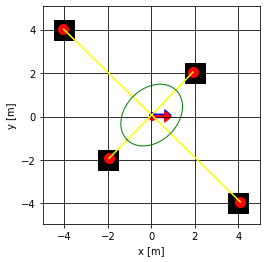

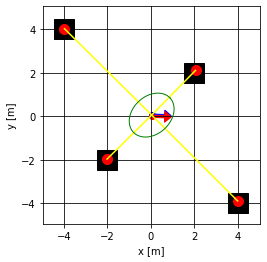

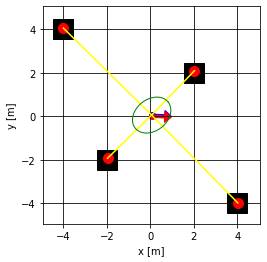

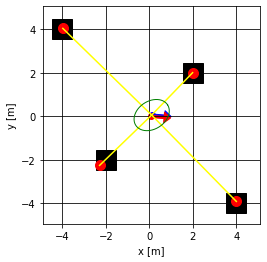

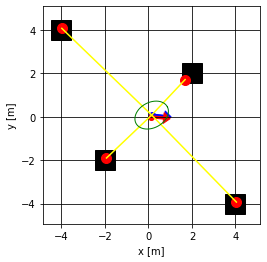

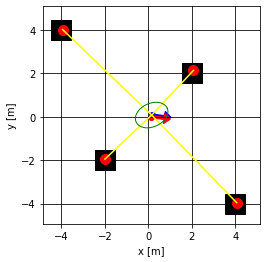

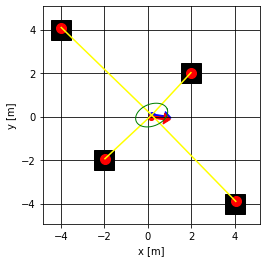

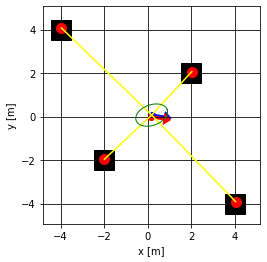

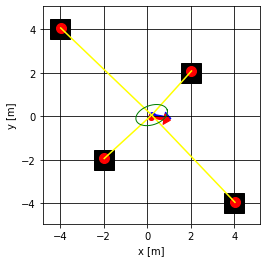

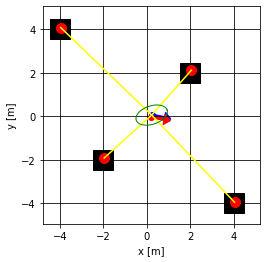

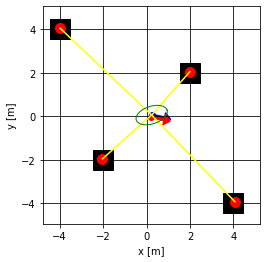

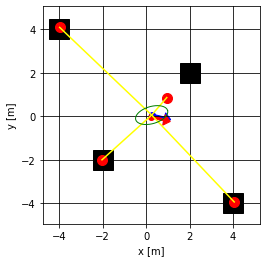

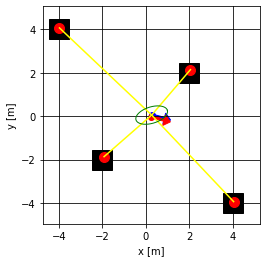

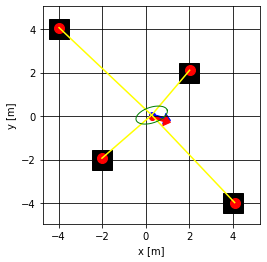

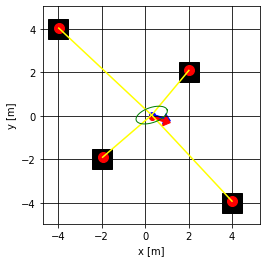

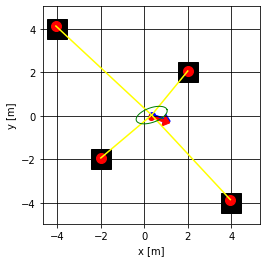

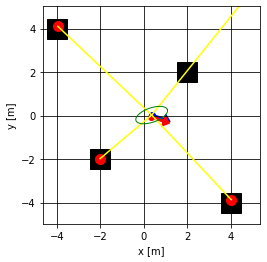

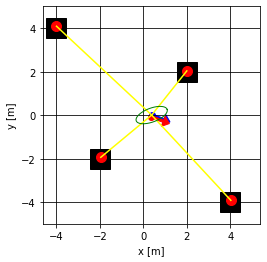

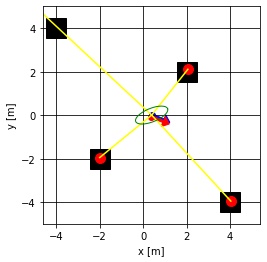

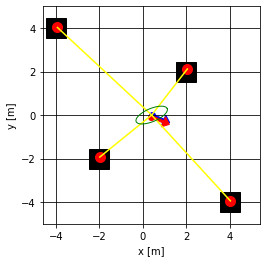

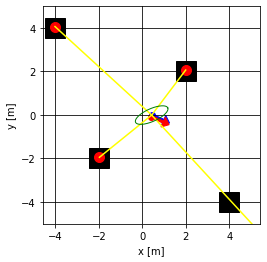

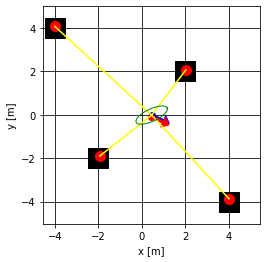

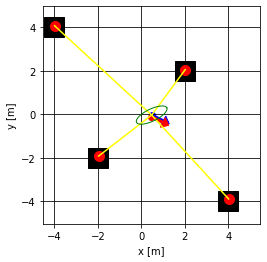

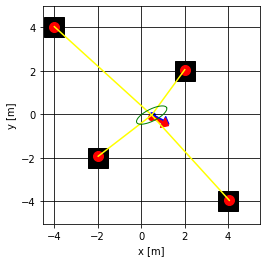

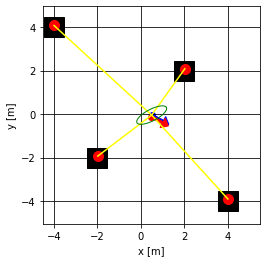

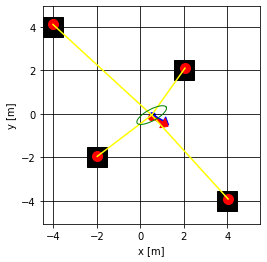

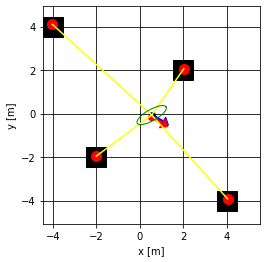

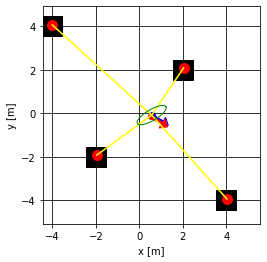

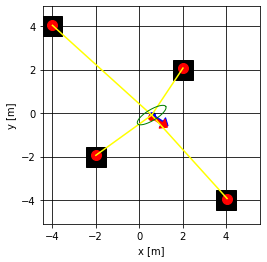

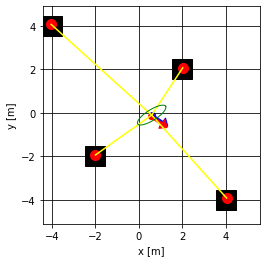

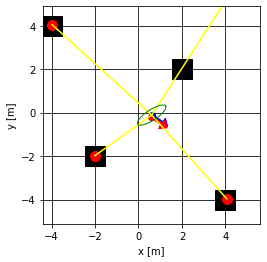

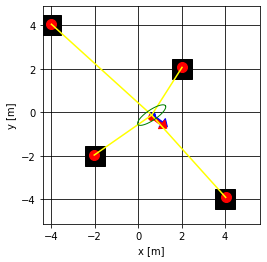

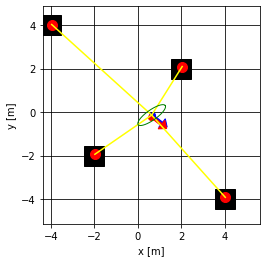

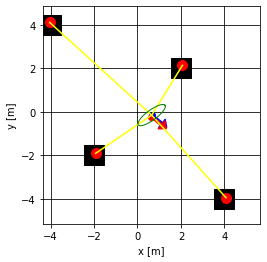

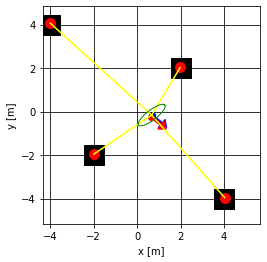

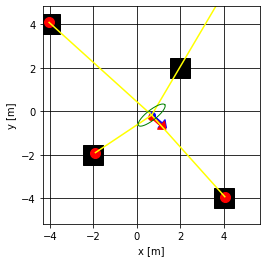

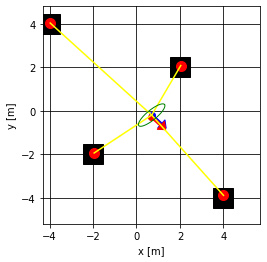

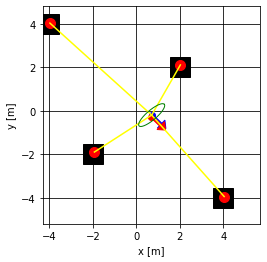

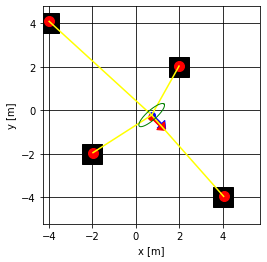

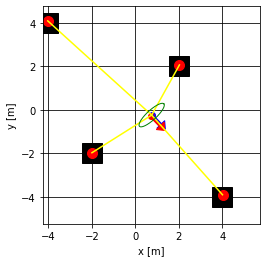

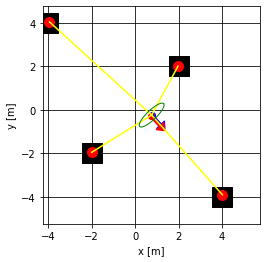

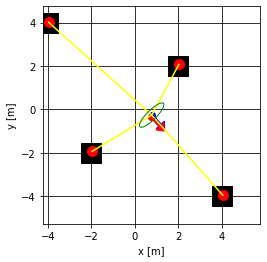

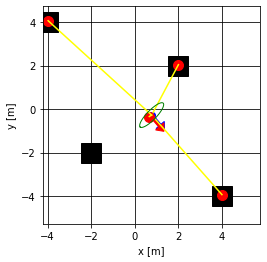

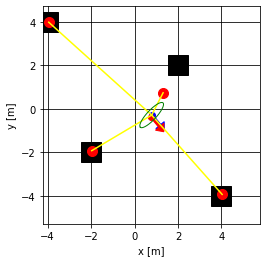

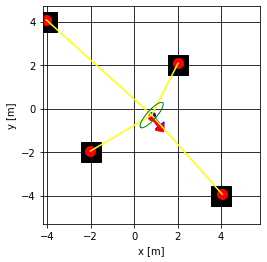

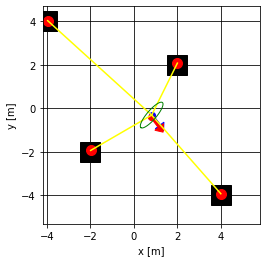

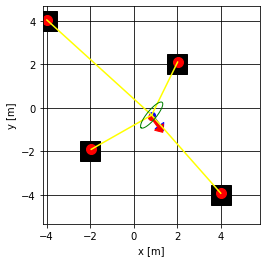

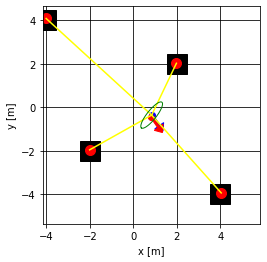

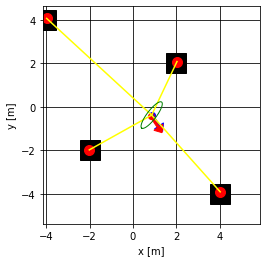

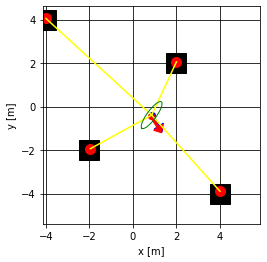

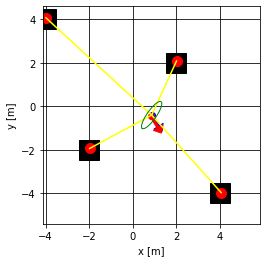

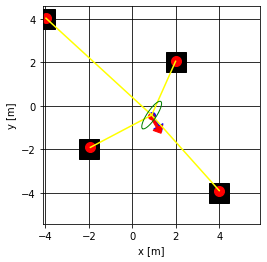

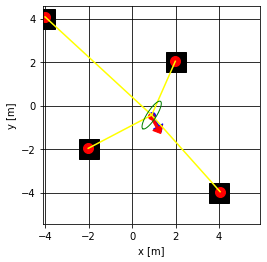

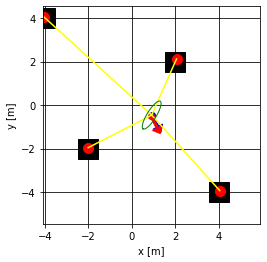

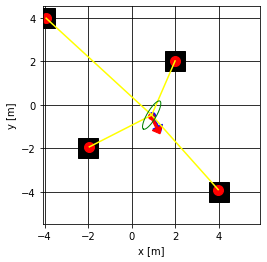

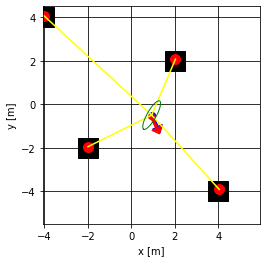

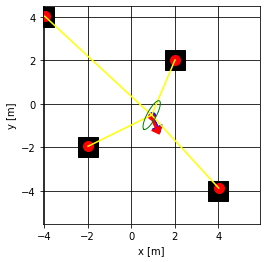

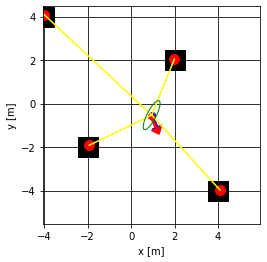

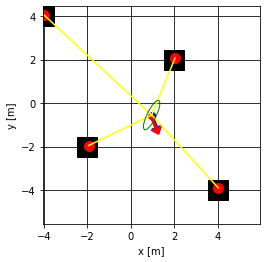

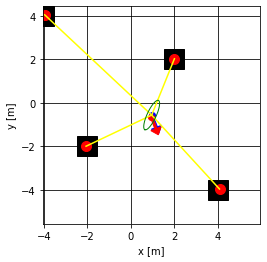

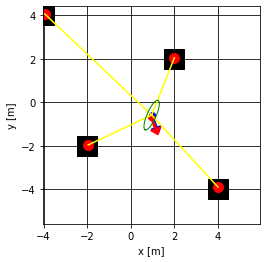

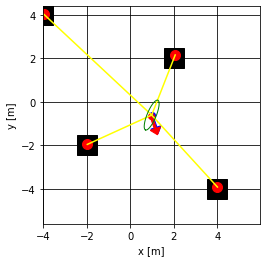

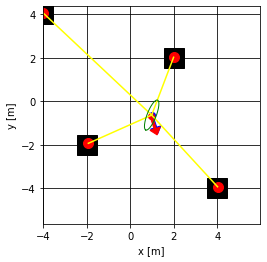

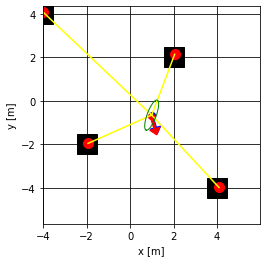

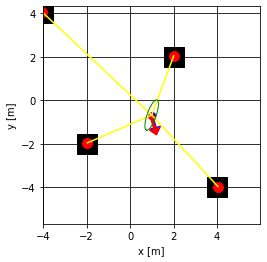

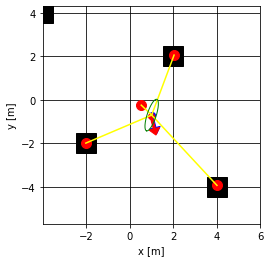

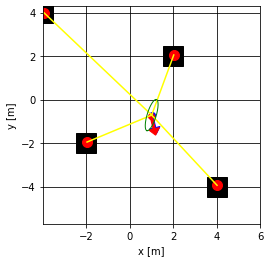

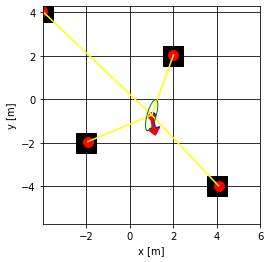

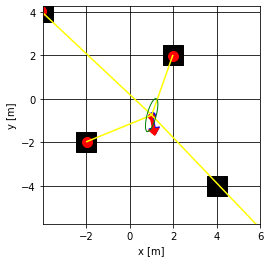

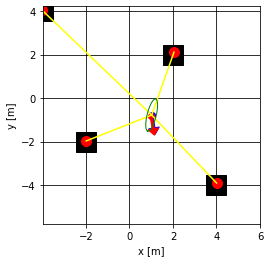

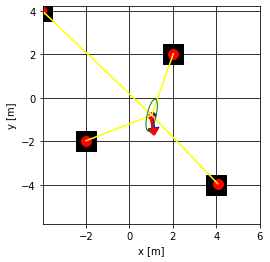

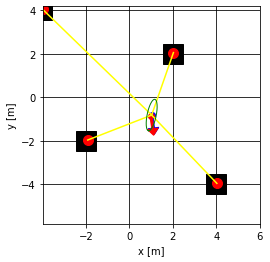

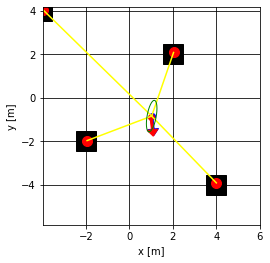

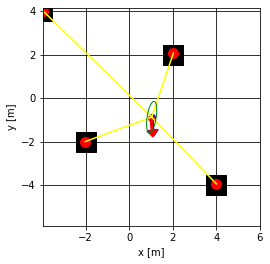

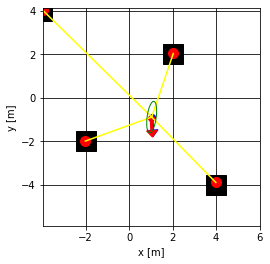

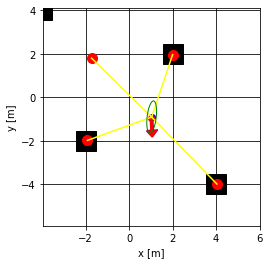

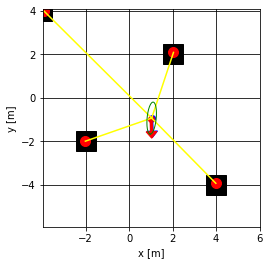

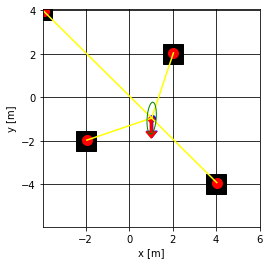

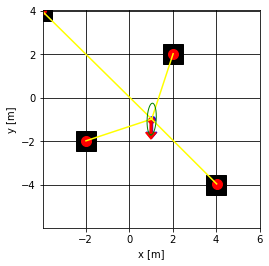

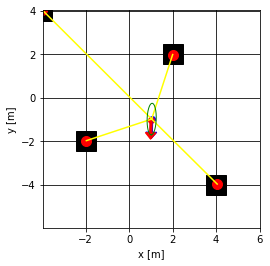

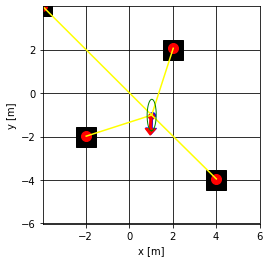

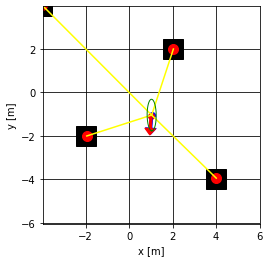

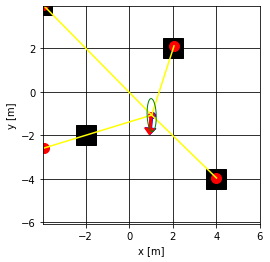

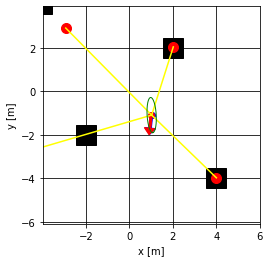

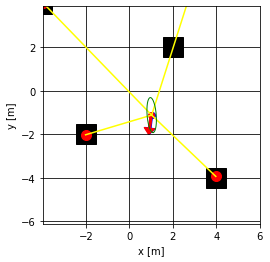

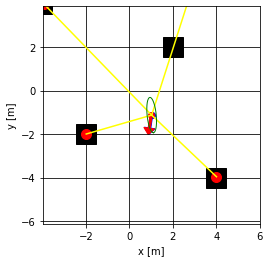

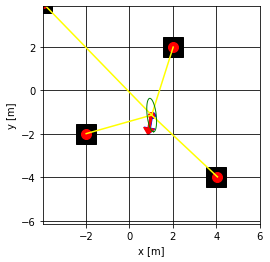

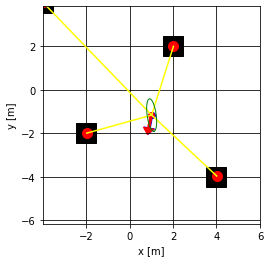

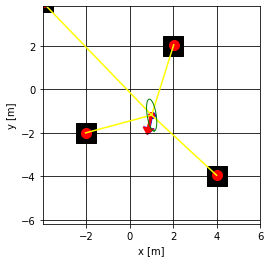

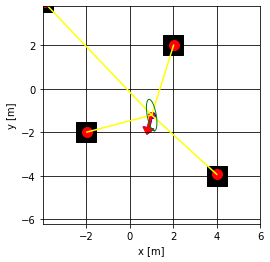

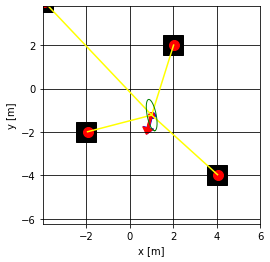

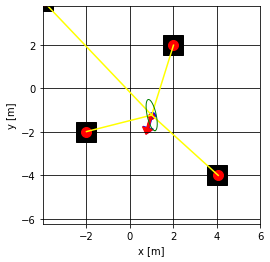

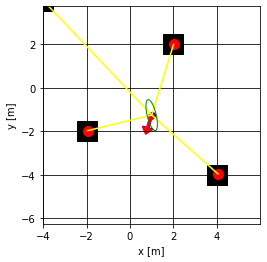

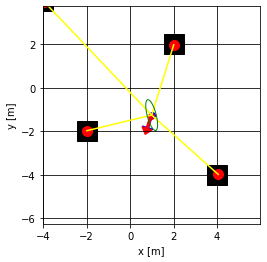

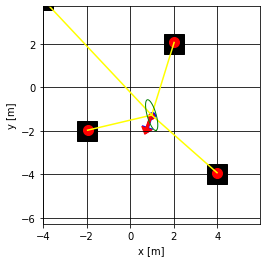

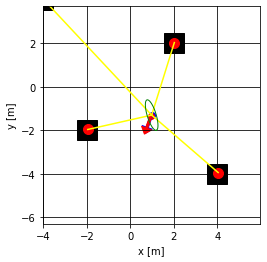

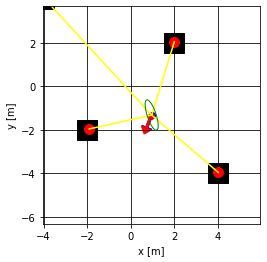

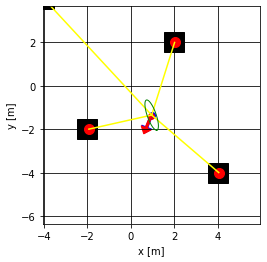

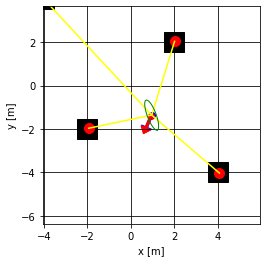

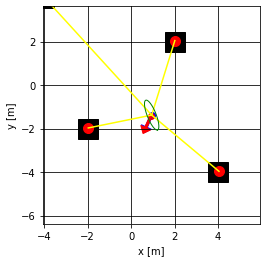

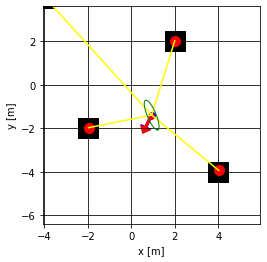

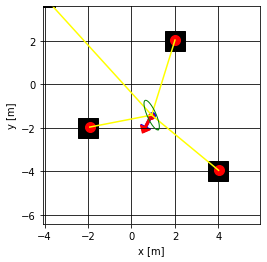

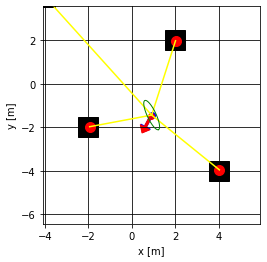

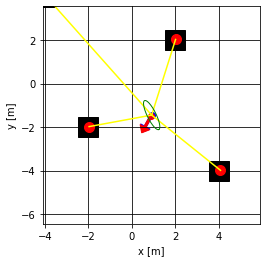

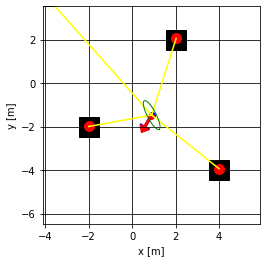

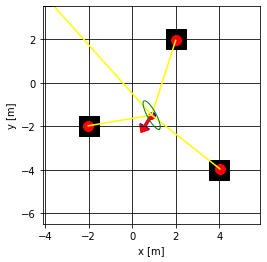

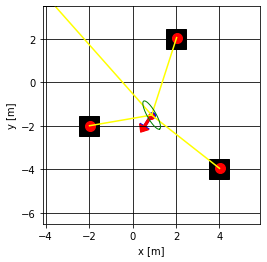

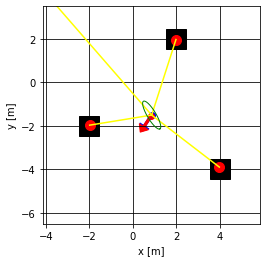

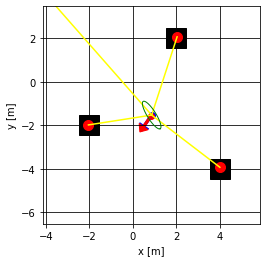

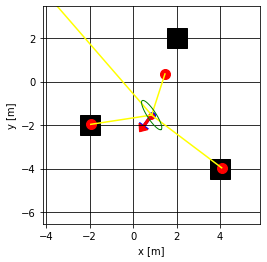

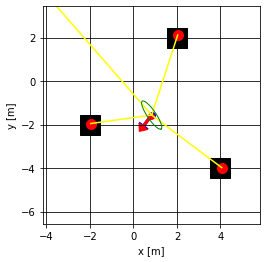

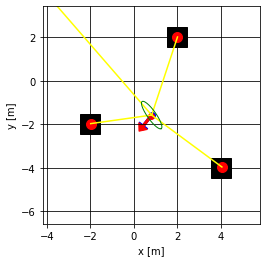

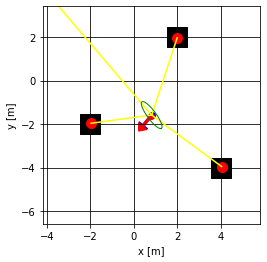

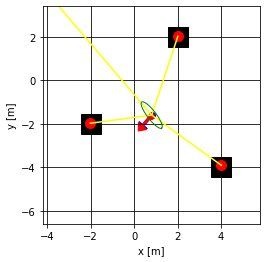

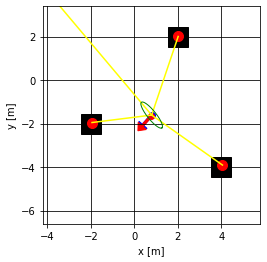

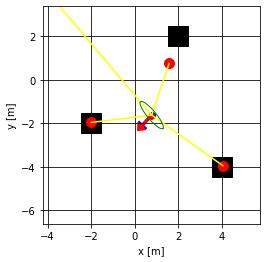

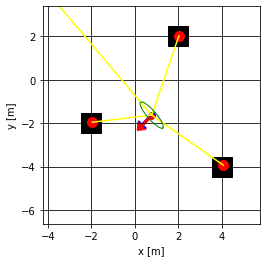

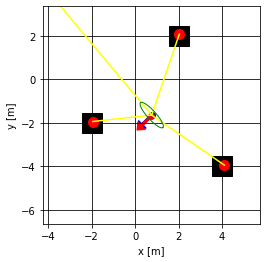

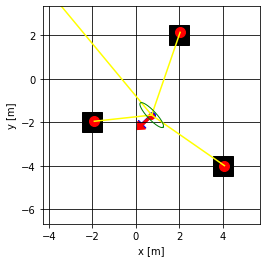

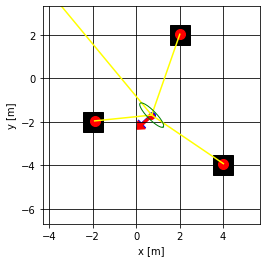

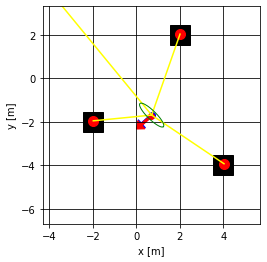

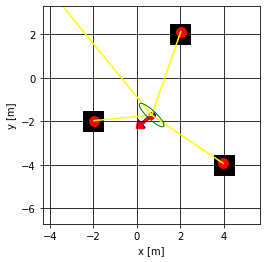

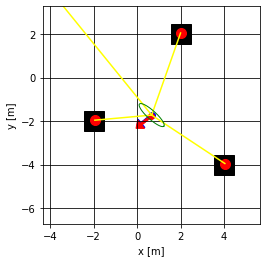

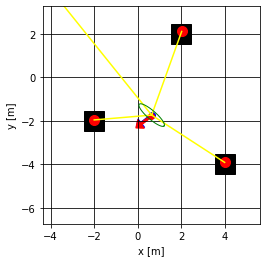

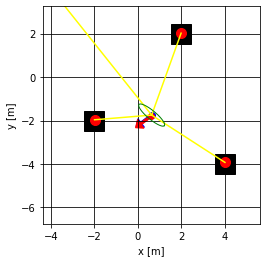

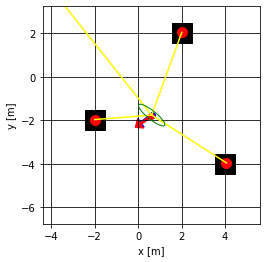

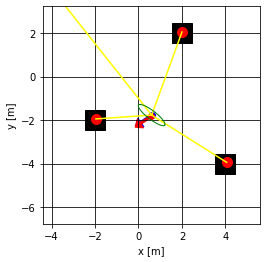

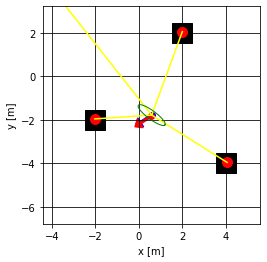

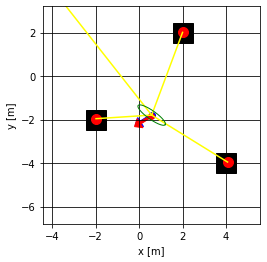

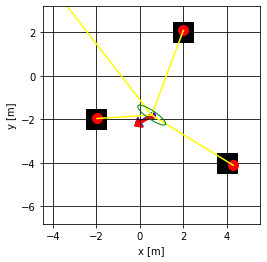

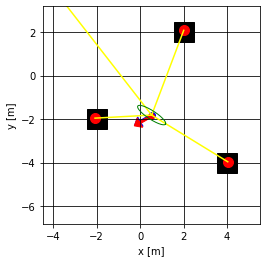

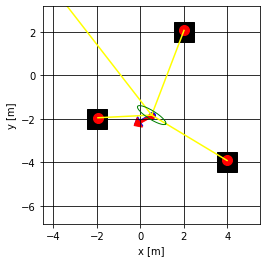

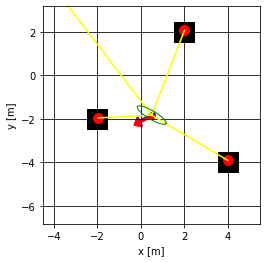

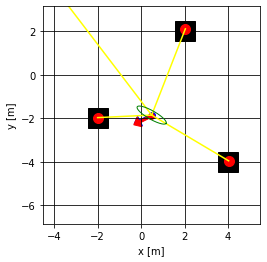

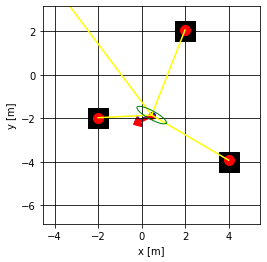

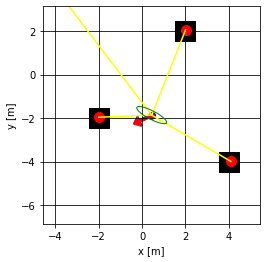

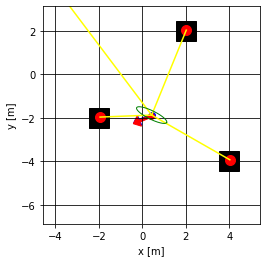

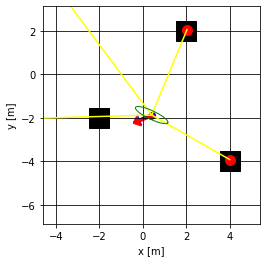

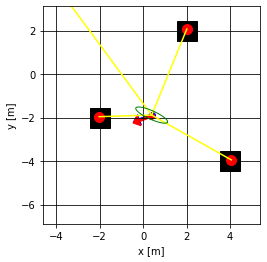

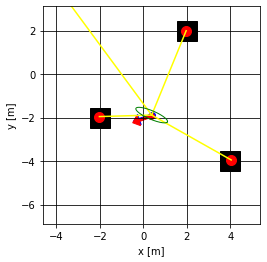

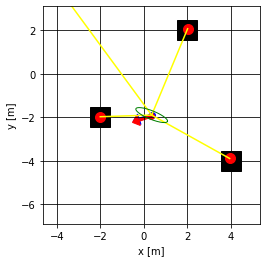

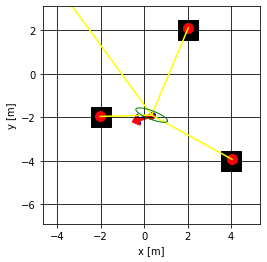

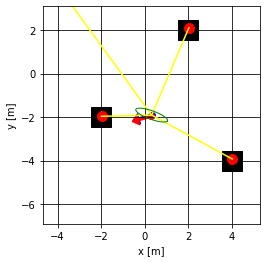

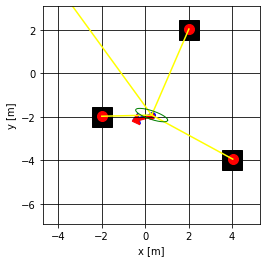

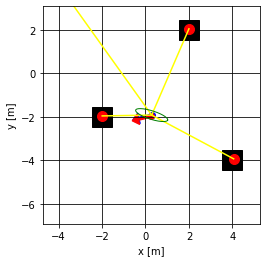

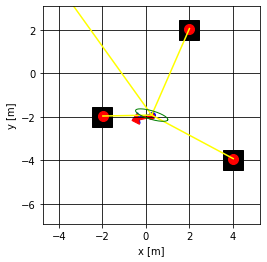

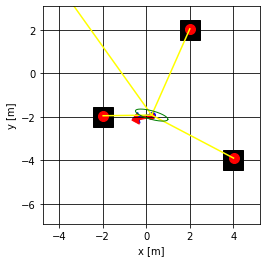

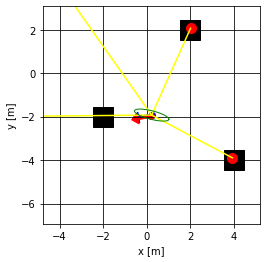

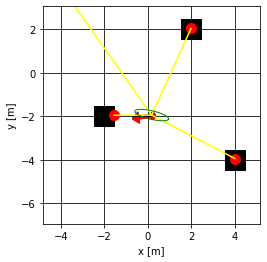

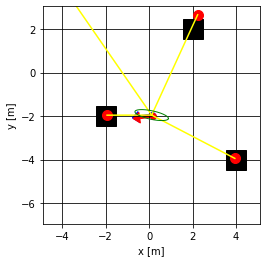

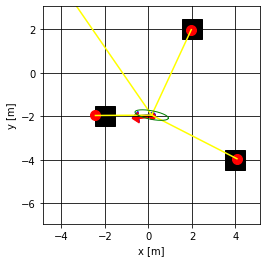

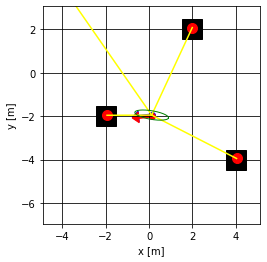

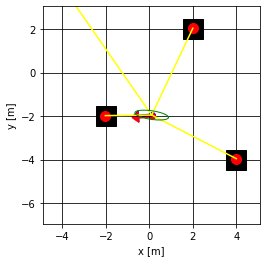

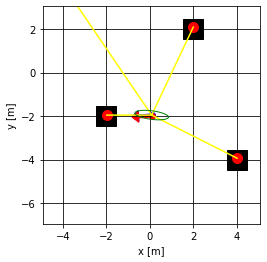

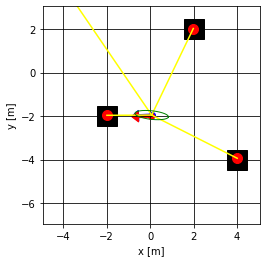

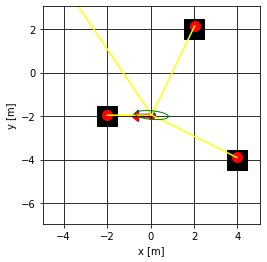

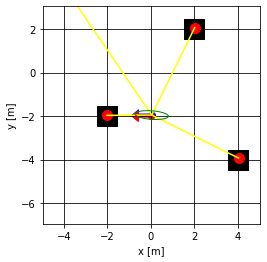

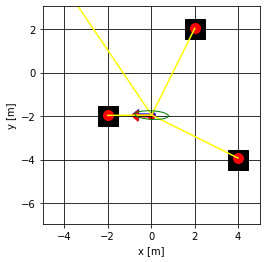

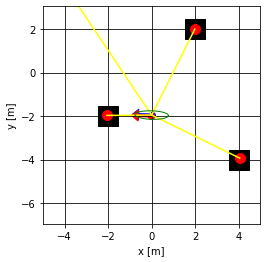

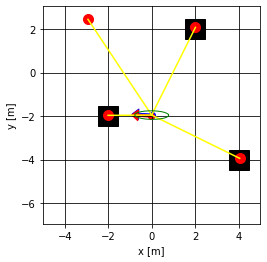

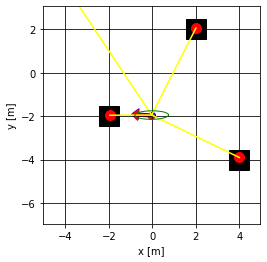

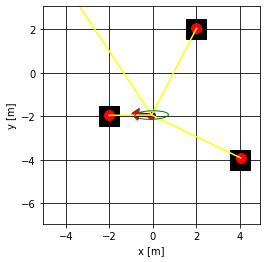

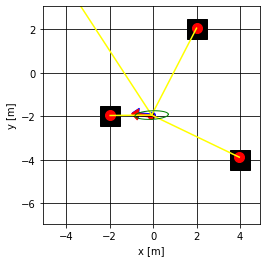

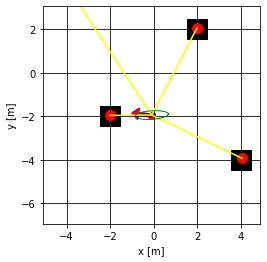

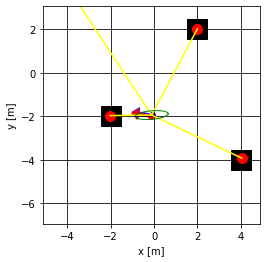

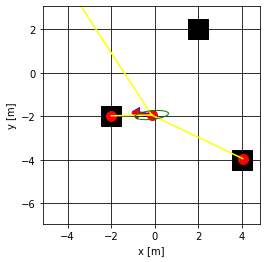

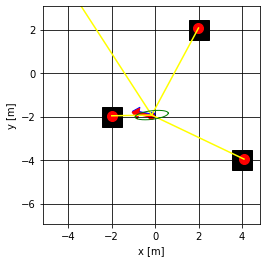

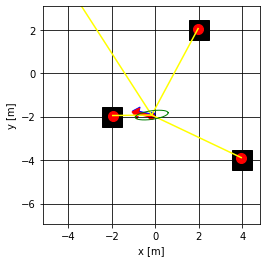

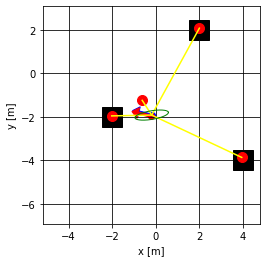

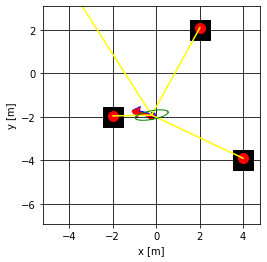

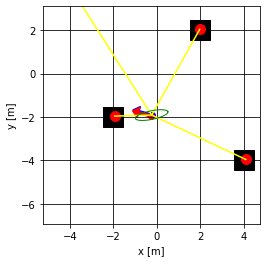

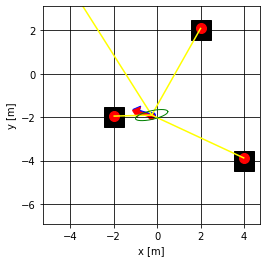

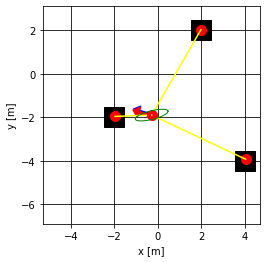

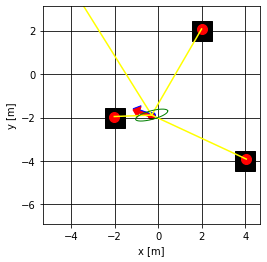

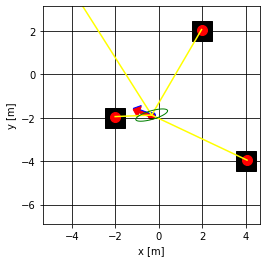

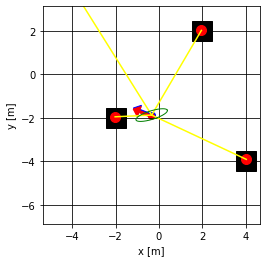

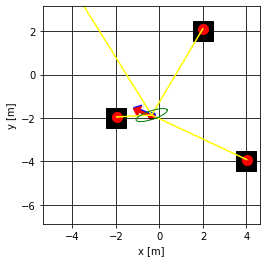

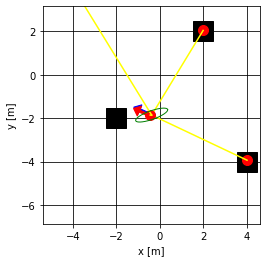

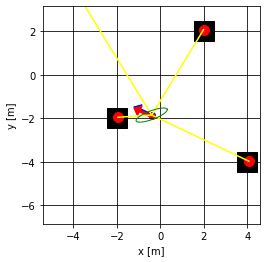

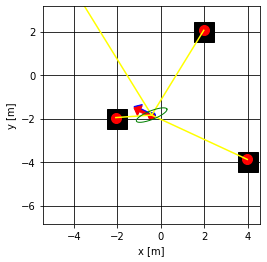

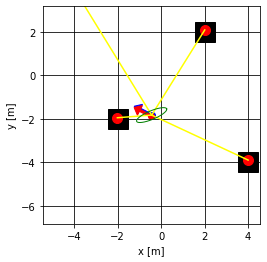

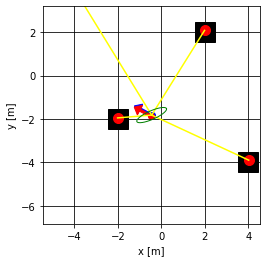

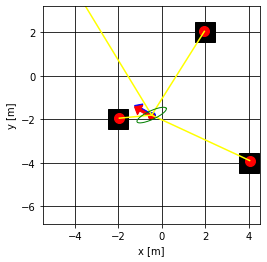

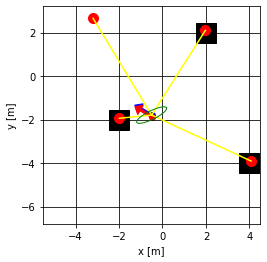

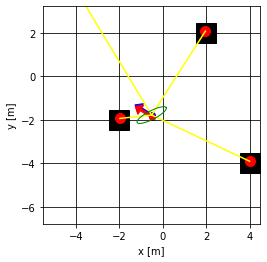

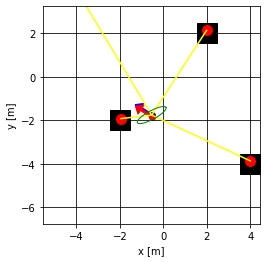

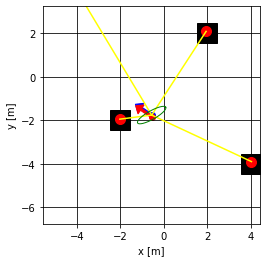

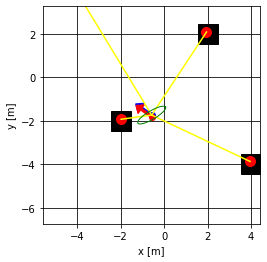

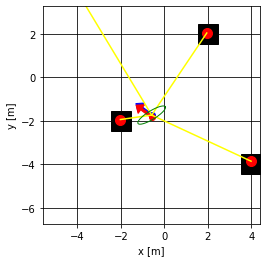

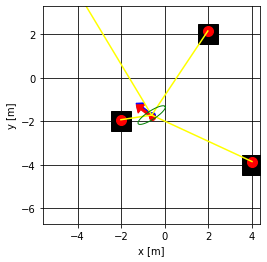

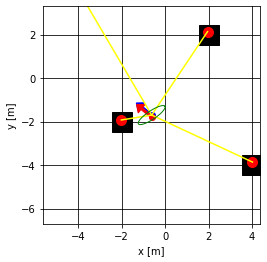

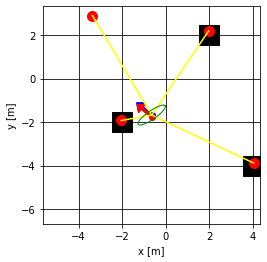

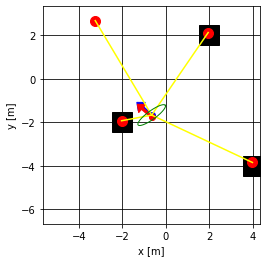

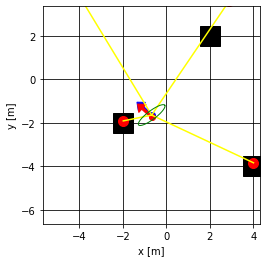

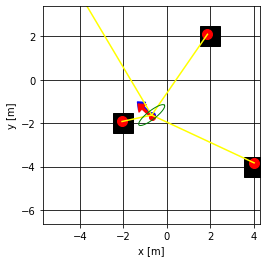

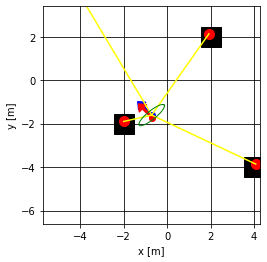

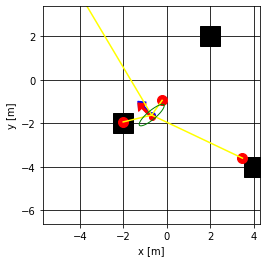

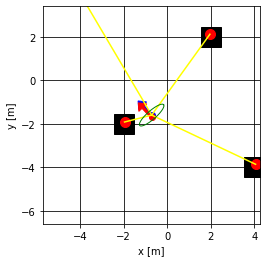

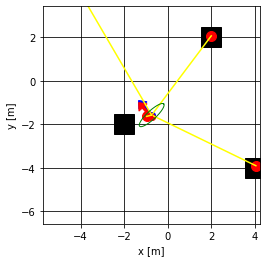

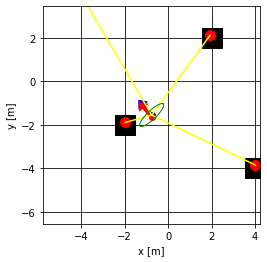

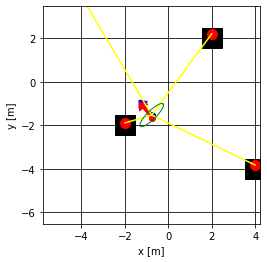

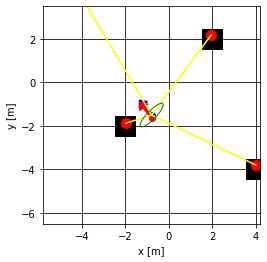

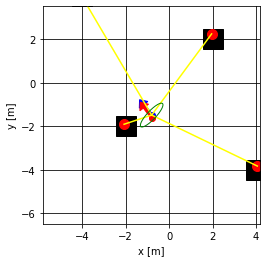

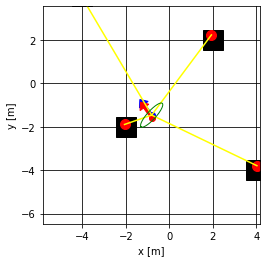

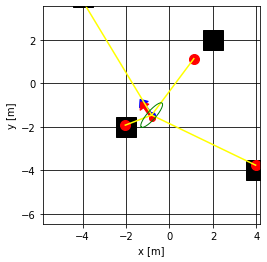

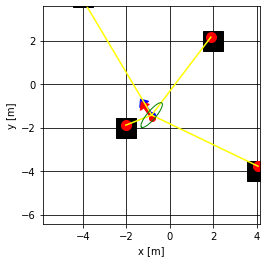

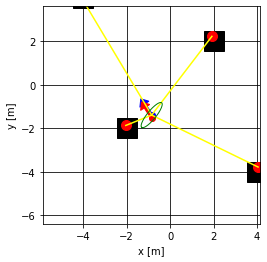

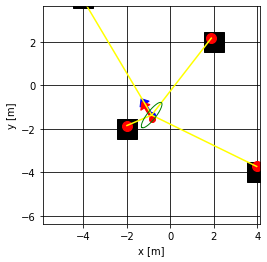

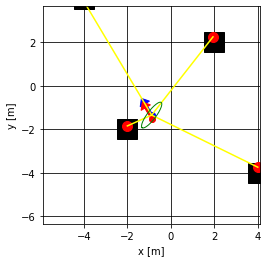

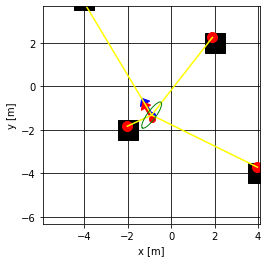

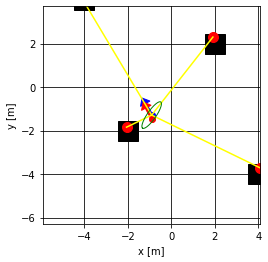

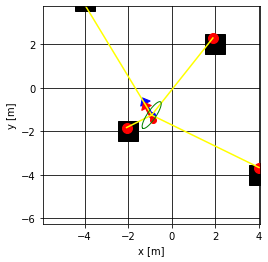

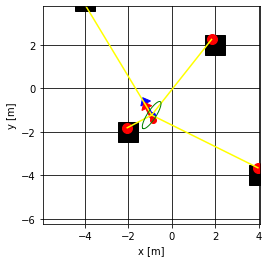

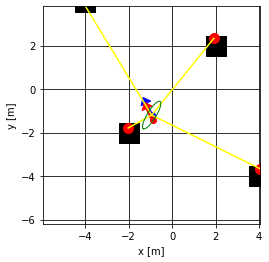

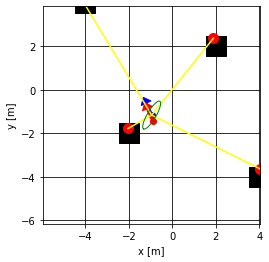

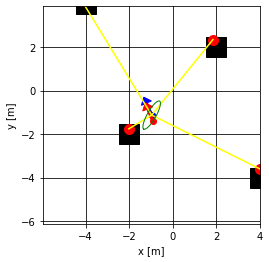

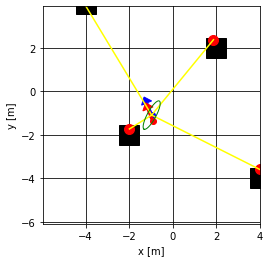

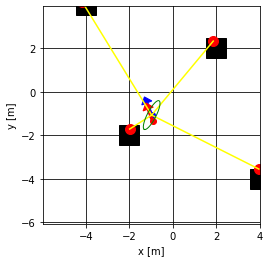

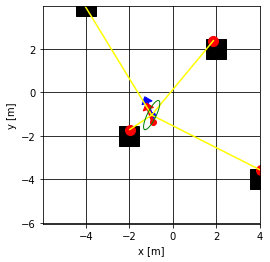

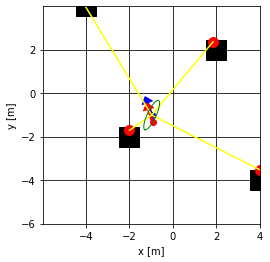

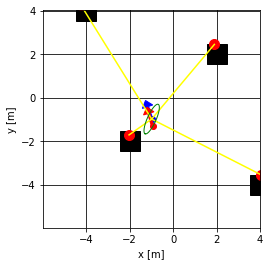

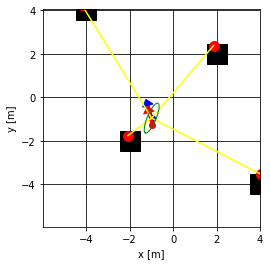

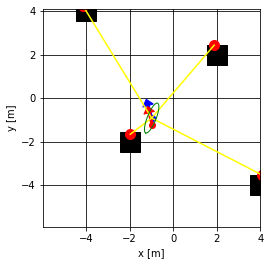

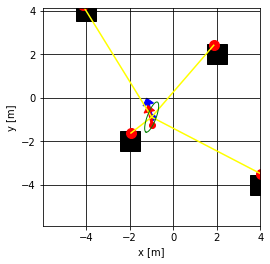

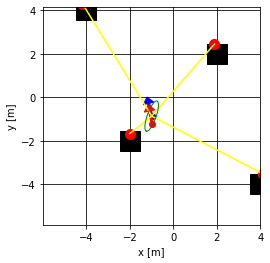

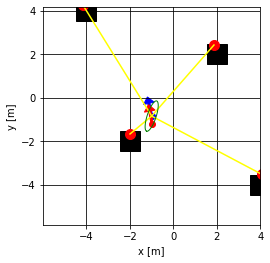

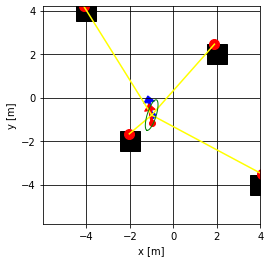

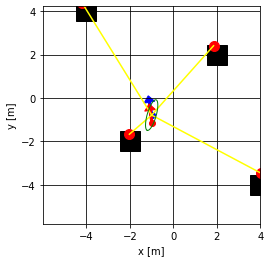

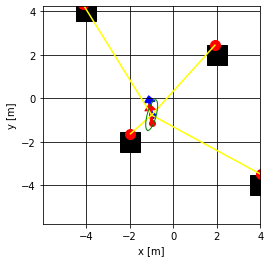

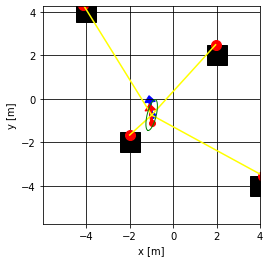

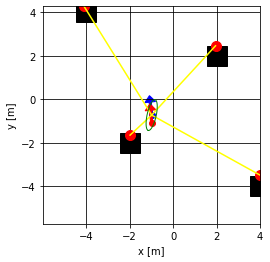

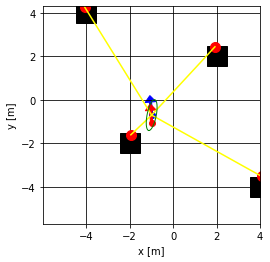

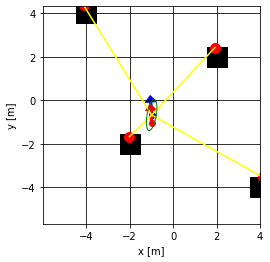

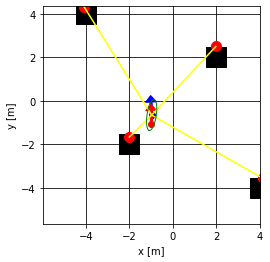

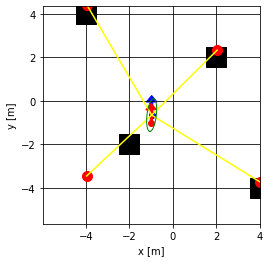

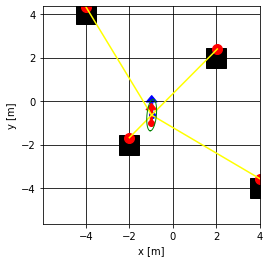

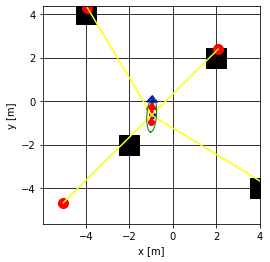

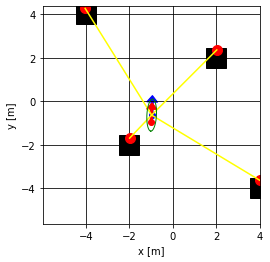

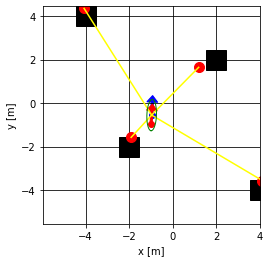

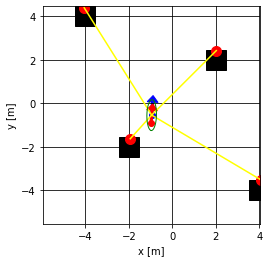

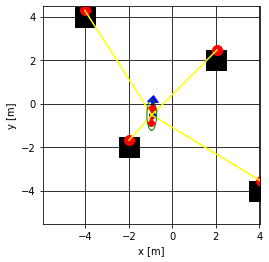

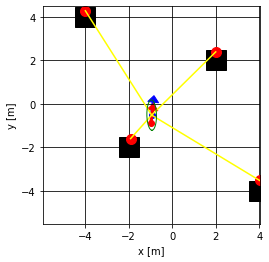

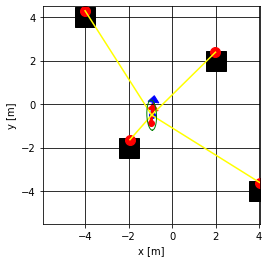

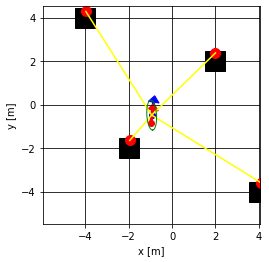

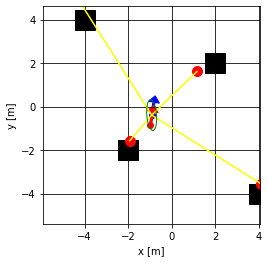

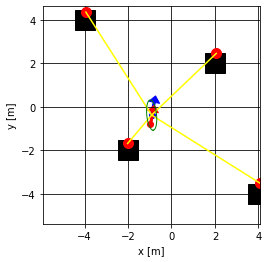

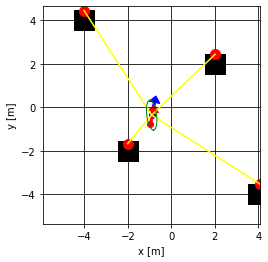

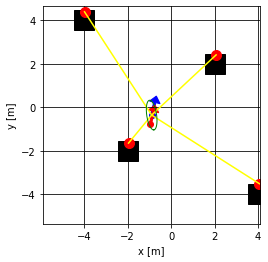

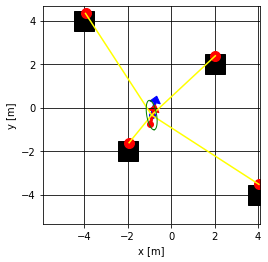

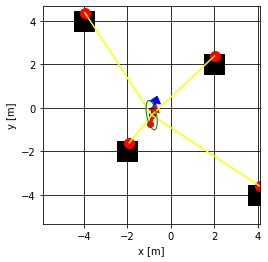

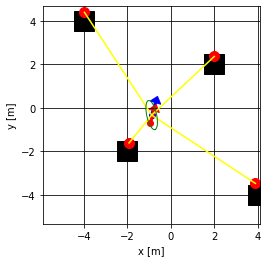

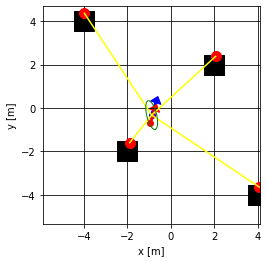

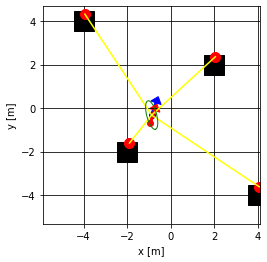

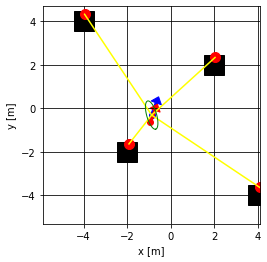

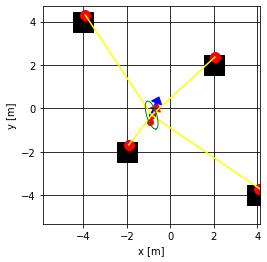

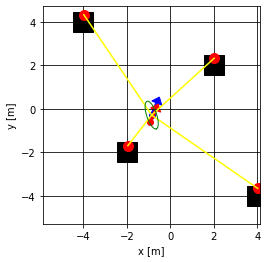

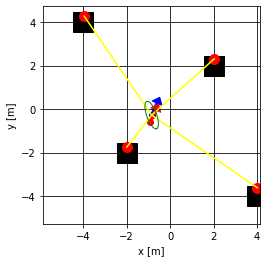

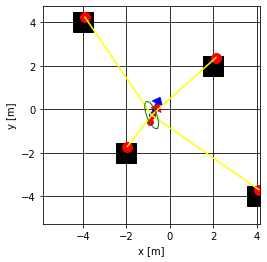

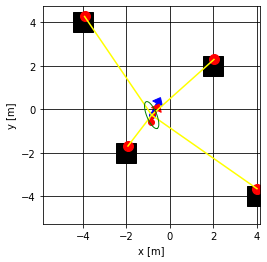

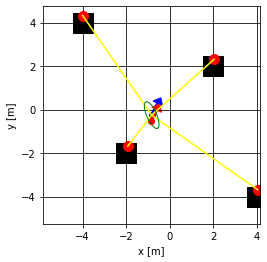

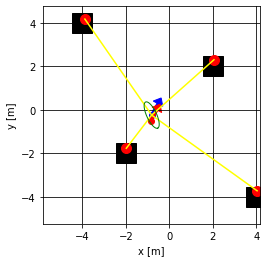

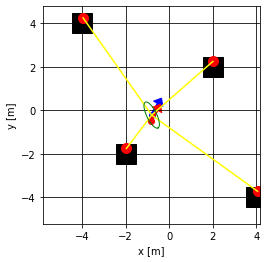

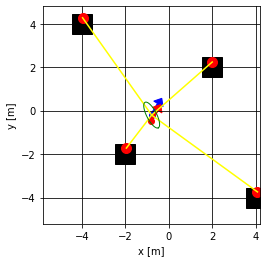

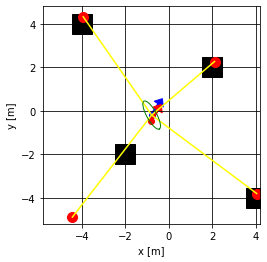

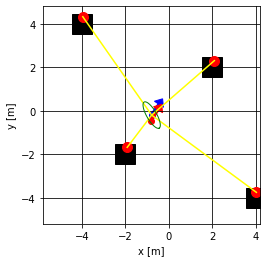

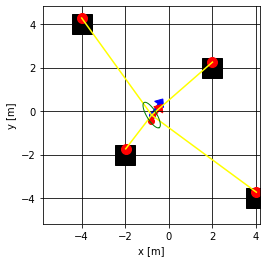

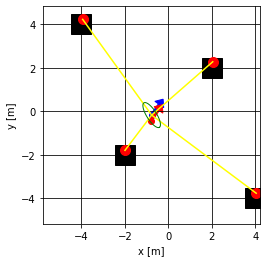

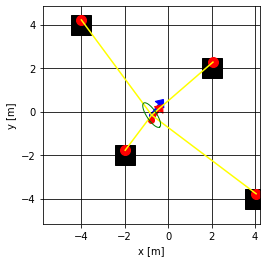

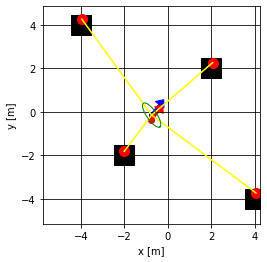

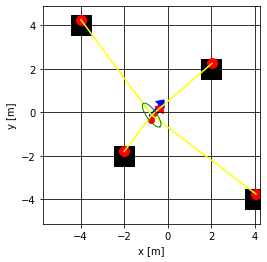

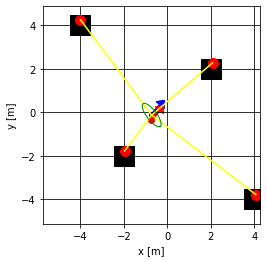

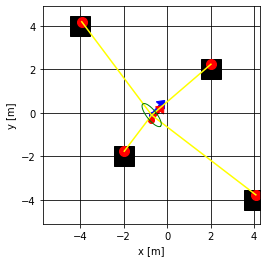

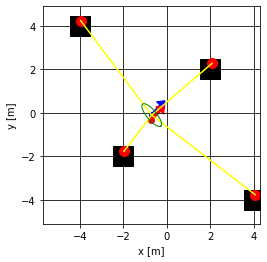

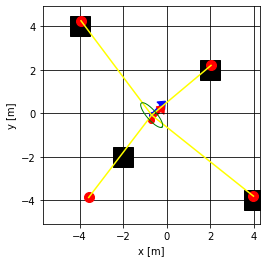

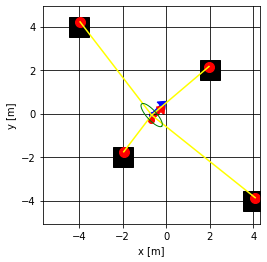

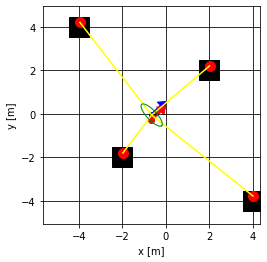

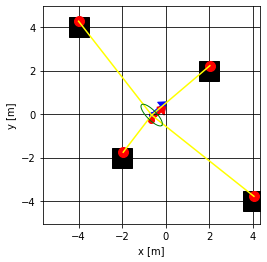

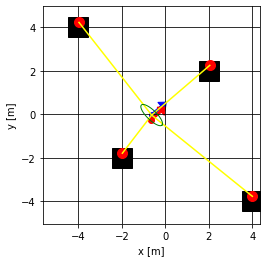

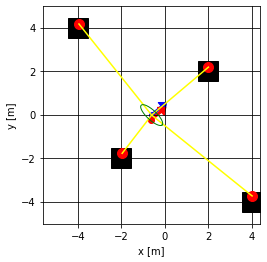

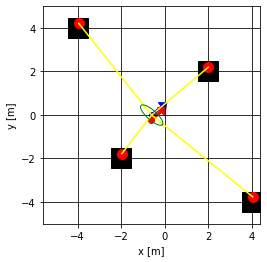

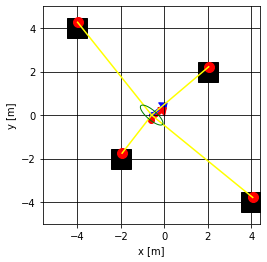

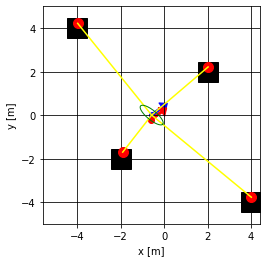

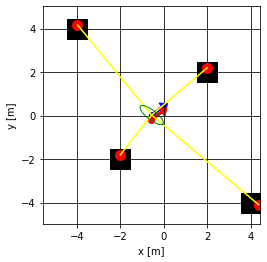

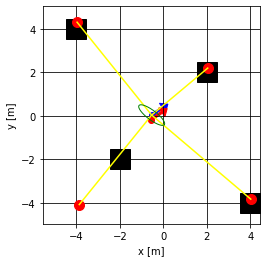

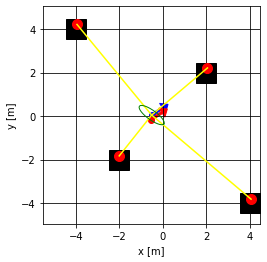

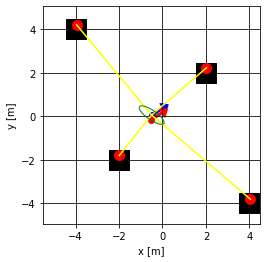

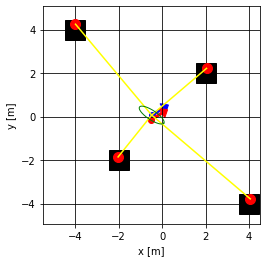

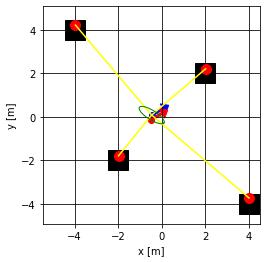

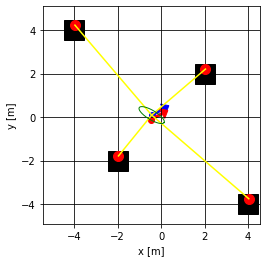

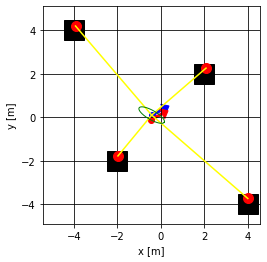

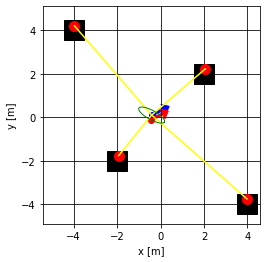

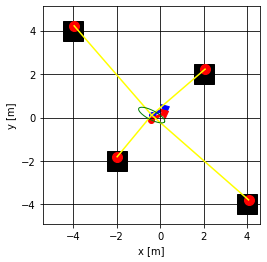

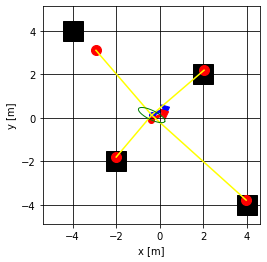

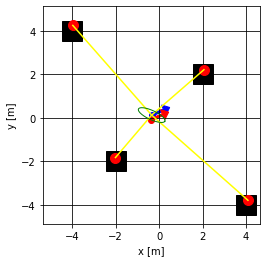

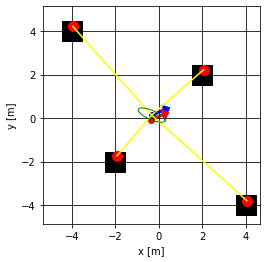

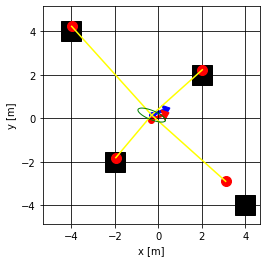

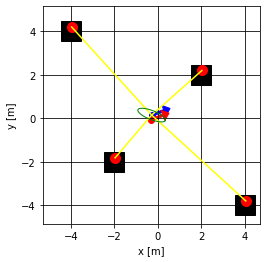

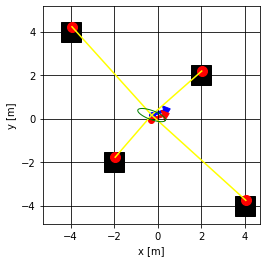

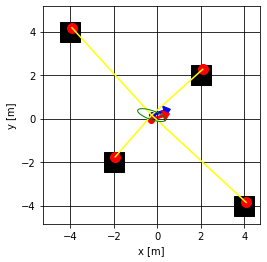

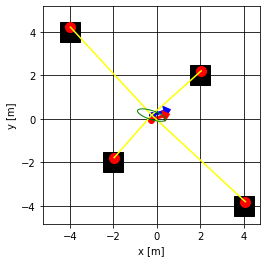

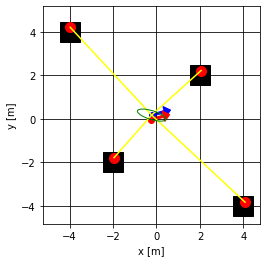

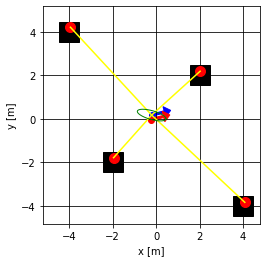

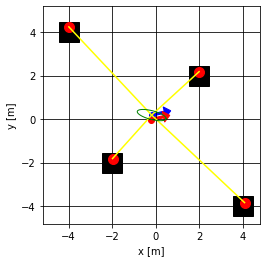

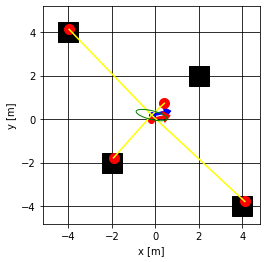

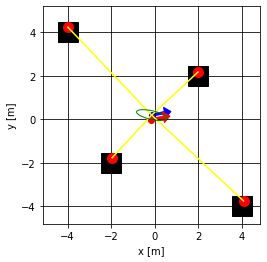

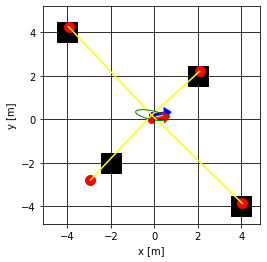

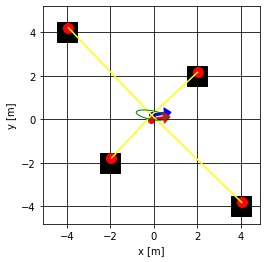

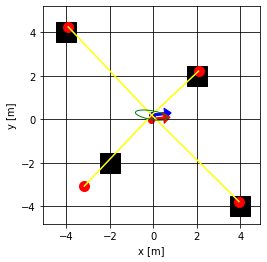

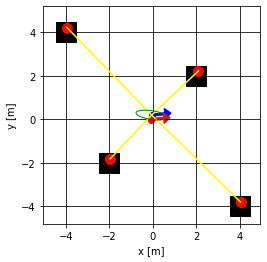

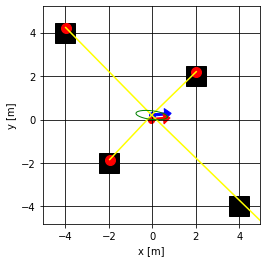

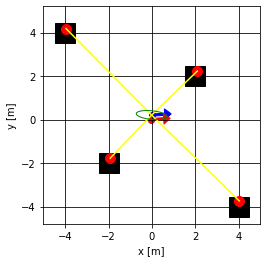

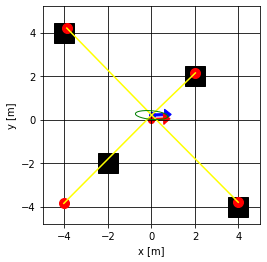

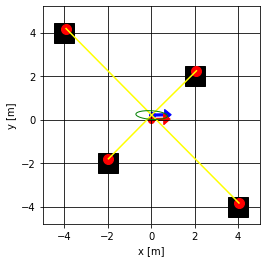

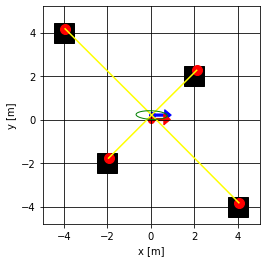

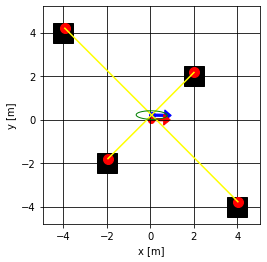

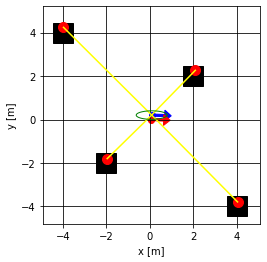

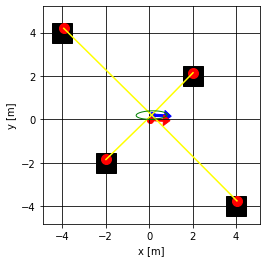

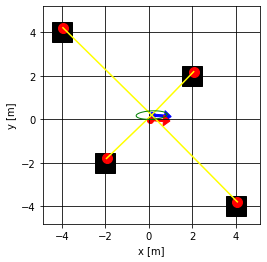

KeyboardInterrupt: 

In [7]:
while True:
    #シュミレーションの更新
    robot_sim.update_pose()
    delta_dist = robot_sim.sim_v * robot_sim.sim_time_step
    delta_yaw = robot_sim.sim_w * robot_sim.sim_time_step
    measurements = robot_sim.get_sensor_measurements()
    ekf.gt_pose(robot_sim.gt_x, robot_sim.gt_y, robot_sim.gt_yaw)

    # EKF
    ekf.predict(delta_dist, delta_yaw)
    ekf.update(measurements)
    ekf.plot_ekf_world(measurements)

    time.sleep(robot_sim.sim_time_step)